In [ ]:
# Copyright 2023 Regeneron Pharmaceuticals Inc.
#
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
#     http://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

## Collect TCR-VALID representations of antigen-labeled TCRs and cluster them

In [2]:
import numpy as np
import pandas as pd

import seaborn as sns
import matplotlib.pyplot as plt

from tcrvalid.load_models import *
from tcrvalid.physio_embedding import SeqArrayDictConverter
from tcrvalid.data_subsetting import *
from tcrvalid.cluster_loop import *
from tcrvalid.defaults import *

(21, 7)
(22, 8)


#### Data and model specificication

Choose to load from_keras to get the model co-packaged with tcr-valid

Model for TRA and TRB to use to get TCR-VALID representations for each chain.
 - here, use the models trained on the full datasets of TRA/TRB chains

In [3]:
from_keras = True #expect True in github code

model_names = {
    'TRA': ['1_2'],
    'TRB': ['1_2_full_40']
}

In [4]:
def get_features(df,trb_model=None,tra_model=None):
    """ Use dataframe of labeled TCRs and TCR-VALID TRA/TRB models to get features
    
    parameters
    -----------
    
    df: pd.DataFrame
        Dataframe of TCRs - expect labeled dataframe for this function. 
        In particular - pre_feature_TRB and/or pre_feature_TRA should be available
        columns containg the sequences to be put through TCR-VALID model. 
        Here those columns contain CDR2-CD3 sequences
        
    trb_model: tf model
        If None, don't include TRB features. Else use representation of this model. If
        tra_model also not None, features from two models are concatenated.
        
    tra_model: tf model
        If None, don't include TRA features. Else use representation of this model. If
        trb_model also not None, features from two models are concatenated. 
    
    """
    if trb_model is not None:
        f_l_trb = mapping.seqs_to_array(df.pre_feature.values,maxlen=28)
        x_l_trb,_,_ = trb_model.predict(f_l_trb)
    if tra_model is not None:
        f_l_tra = mapping.seqs_to_array(df.pre_feature_TRA.values,maxlen=28)
        x_l_tra,_,_ = tra_model.predict(f_l_tra)

    #y_l = df_labelled.label.values

    if tra_model is not None and trb_model is not None:
        print(x_l_trb.shape)
        print(x_l_tra.shape)
        x_l = np.concatenate([x_l_trb, x_l_tra],axis=1)
    elif tra_model is None:
        x_l = x_l_trb
    elif trb_model is None:
        x_l = x_l_tra
    else:
        raise ValueError()

    return x_l

### Define mapping to phyiscochemical properties and TCR-VALID models

In [5]:
mapping = SeqArrayDictConverter()

loaded_trb_models = load_named_models(model_names['TRB'],chain='TRB',as_keras=from_keras)
loaded_tra_models = load_named_models(model_names['TRA'],chain='TRA',as_keras=from_keras)

tra_model = loaded_tra_models['1_2']
trb_model = loaded_trb_models['1_2_full_40']

2023-10-26 12:39:39.287353: E tensorflow/stream_executor/cuda/cuda_driver.cc:271] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
2023-10-26 12:39:39.287401: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (gen-queue-dy-m516xlarge-58): /proc/driver/nvidia/version does not exist
2023-10-26 12:39:39.288660: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


dfsubset_df#### Load in the antigen-labeled data

 - make_subset() selects for the chosen type of problem
    - here, paired chain, based on CDR2 and CDR3, using 'both' labeled datasets (includes dextramer data)
    - internally removes any duplicates
    
 - get_features() collects TCR-VALID representation for paired-chain TCRs in the dataframe
    

In [6]:
df = pd.read_csv(labelled_data_path)
sources = sources_['both']
chains = chains_['TRB']
feature = features_['CDR23']
subset_df = make_subset(df,sources=sources,chains=chains,feature=feature,min_size=3, max_len=28)

x_l = get_features(
  subset_df,
  trb_model=trb_model,
  tra_model=None
)

/data/home/allen.leary/repos/tcrvalid/tcrvalid/data_subsetting.py:75: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['pre_feature'] = df['cdr2_no_gaps'] + '-' + df.junction_aa.map(lambda x: x[1:-1])


#### Cluster TCRs for a range of 'distance thresholds' with DBSCAN

 - set a range of 'epsilon' values for the DBSCAN clustering which sets a distance threshold 
 - Perform clustering on the labeled dataset for these distances and store results in a dataframe 

In [11]:
#eps_range = np.linspace(2.0,12.0,10)
eps_range = np.linspace(0.1,10.0,20)

scores_df = dbscan_loop(
    subset_df,
    x_l,
    eps_range,
    metric='manhattan',
    min_samples=2,
    eps_format=':.2f'
)

In [32]:
scores_df['epsilon_scaled']=(scores_df['epsilon']-scores_df['epsilon'].min())/(scores_df['epsilon'].max()-scores_df['epsilon'].min())
scores_df=scores_df.rename(columns={"well_clustered_total": "c-CSI","well_clustered": "c-precision"})

#### Take a look at the scores for each threshold

In [33]:
scores_df

,n_clusters,n_epitopes_captured,percent_clustered,percent_clustered_in_largest,percent_labeled_clustered,mean_purity,c-CSI,c-precision,epsilon,epsilon_scaled
eps_0.10,1.0,1.0,0.066401,0.066401,0.066401,100.000000,0.066401,100.000000,0.10,0.000000
eps_0.62,85.0,9.0,8.034529,0.431607,8.034529,98.137255,7.669323,95.454545,0.62,0.052525
eps_1.14,97.0,12.0,14.043825,1.361222,14.043825,97.311625,13.512616,96.217494,1.14,0.105051
eps_1.66,105.0,13.0,18.492696,3.884462,18.492696,95.251693,17.297477,93.536804,1.66,0.157576
eps_2.18,144.0,15.0,24.070385,10.192563,24.070385,91.514904,21.447543,89.103448,2.18,0.210101
eps_2.71,186.0,17.0,29.880478,11.719788,29.880478,86.030939,24.435591,81.777778,2.71,0.263636
eps_3.23,227.0,18.0,36.520584,12.516600,36.520584,83.352368,27.656042,75.727273,3.23,0.316162
eps_3.75,247.0,20.0,43.094290,15.239044,43.094290,76.850085,28.984064,67.257319,3.75,0.368687
eps_4.27,243.0,21.0,50.697211,20.285525,50.697211,73.398137,10.756972,21.218075,4.27,0.421212
eps_4.79,210.0,21.0,59.428951,35.126162,59.428951,69.050192,5.876494,9.888268,4.79,0.473737


#### Plot the curve of clustering-Precision vs clustering-CSI

/tmp/ipykernel_6017/3234763028.py:7: UserWarning: FixedFormatter should only be used together with FixedLocator
  axes2.set_yticklabels(axes2.get_yticks(), size = 12)
/tmp/ipykernel_6017/3234763028.py:8: UserWarning: FixedFormatter should only be used together with FixedLocator
  axes2.set_xticklabels(axes2.get_xticks(), size = 12)


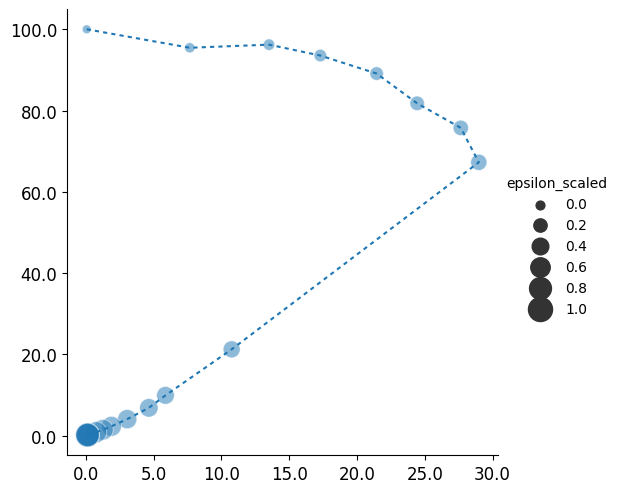

In [34]:
axes=sns.relplot(x='c-CSI', y='c-precision', size='epsilon_scaled',sizes=(40, 300), alpha=.5 ,data=scores_df,legend='brief')
axes2=sns.lineplot(x = 'c-CSI', y = 'c-precision', data = scores_df,sort=False,style=True,dashes=[(2, 2)])
axes2.legend().remove()
axes2.set(xlabel=None)

axes2.set(ylabel=None)
axes2.set_yticklabels(axes2.get_yticks(), size = 12)
axes2.set_xticklabels(axes2.get_xticks(), size = 12)
fig = axes.fig